Installation: https://qiskit.org/documentation/install.html

In [1]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.optimizers import COBYLA, SLSQP
from qiskit import BasicAer,execute, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua import QuantumInstance
from qiskit.circuit import QuantumRegister, QuantumCircuit, Parameter, ParameterVector

### Prepare the molecule for computation

Firstly, let's define $H_2$ molecule. We will use PySCF, a package with electronic structure programs, that has integration in Qiskit. For more details: https://qiskit.org/documentation/apidoc/qiskit.chemistry.drivers.html

In [2]:
bond_length = .735

driver = PySCFDriver(
    atom = f"H .0 .0 .0; H .0 .0 {bond_length}",
    unit = UnitsType.ANGSTROM,
    charge = 0,
    spin = 0,
    basis = 'sto3g'
)

molecule = driver.run()

The driver provides a lot of useful information about the molecule that will be used during the computations

In [3]:
print("Hartree-Fock energy:")
print(molecule.hf_energy)
print()
print("Nuclear repulsion energy:")
print(molecule.nuclear_repulsion_energy)

Hartree-Fock energy:
-1.1169989967540044

Nuclear repulsion energy:
0.7199689944489797


Specifically, we can get the number of particles, spin orbitals, and repulsion energy

In [4]:
repulsion_energy = molecule.nuclear_repulsion_energy

# For the closed-shell molecules
num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2

print(f"Number of particles: {num_particles}")
print(f"Number of spin orbitals: {num_spin_orbitals}")

Number of particles: 2
Number of spin orbitals: 4


We define fermionic operator, which is Hamiltonian in second quantized form. One- and two-body integrals are computed classically

$
H = \sum_{i, j}h_{ij}a^\dagger_ia_j + \frac{1}{2}\sum_{i, j, k, l}h_{ijkl}a^\dagger_i a^\dagger_j a_k a_l
$

FermionicOperator: https://qiskit.org/documentation/stubs/qiskit.chemistry.FermionicOperator.html

In [21]:
ferOp = FermionicOperator(
    h1 = molecule.one_body_integrals, 
    h2 = molecule.two_body_integrals
)
qubitOp = ferOp.mapping(
    map_type='jordan_wigner', 
    threshold = 1e-8
)
print(qubitOp)

Representation: paulis, qubits: 4, size: 15


`qubitOp` is qubit Hamiltonian after mapping. Here we use Jordan-Wigner transformation, but also Parity, Bravyi-Kitaev are possible.

In [22]:
print(qubitOp.print_details())

IIII	(-0.8105479805373266+0j)
IIIZ	(0.1721839326191556+0j)
IIZI	(-0.22575349222402474+0j)
IZII	(0.17218393261915557+0j)
ZIII	(-0.22575349222402474+0j)
IIZZ	(0.1209126326177663+0j)
IZIZ	(0.16892753870087912+0j)
XXYY	(0.045232799946057875+0j)
YYYY	(0.045232799946057875+0j)
XXXX	(0.045232799946057875+0j)
YYXX	(0.045232799946057875+0j)
ZIIZ	(0.16614543256382416+0j)
IZZI	(0.16614543256382416+0j)
ZIZI	(0.17464343068300459+0j)
ZZII	(0.1209126326177663+0j)



### Run VQE

Now we should select backend that will run the computations. Since we use a classical computer, we choose `statevector_simulator`. However, when using a quantum computer, you only need to login and change the backend.

We will use COBYLA as an optimizer. Qiskit also supports multiple gradient descent algorithms, SLSQP, Powell's method and several more. https://qiskit.org/documentation/apidoc/qiskit.aqua.components.optimizers.html

In [7]:
backend = BasicAer.get_backend("statevector_simulator")
optimizer = COBYLA(maxiter = 200)

Prepare initial Hartree-Fock state. VQE-UCCSD requires Hartree-Fock initial state.

In [8]:
initial_state = HartreeFock(
    num_spin_orbitals,
    num_particles,
    two_qubit_reduction = False,
    qubit_mapping = 'jordan_wigner'
)
print(initial_state.construct_circuit())

     ┌─────────────┐
q_0: ┤ U3(pi,0,pi) ├
     └─────────────┘
q_1: ───────────────
     ┌─────────────┐
q_2: ┤ U3(pi,0,pi) ├
     └─────────────┘
q_3: ───────────────
                    


First, we will use the UCCSD circuit implemented in Qiskit. For more information about VQE-UCCSD: https://arxiv.org/pdf/1805.04340.pdf

In [24]:
var_form = UCCSD(
    num_orbitals = num_spin_orbitals,
    num_particles = num_particles,
    initial_state = initial_state,
    two_qubit_reduction = False,
    qubit_mapping = 'jordan_wigner',
    excitation_type = 'sd'
)

Qiskit allows to draw crcuits in a convenient form.

In [25]:
number_parameters = var_form.num_parameters
params = ParameterVector('params', number_parameters)
circuit = var_form.construct_circuit(params)
circuit.draw()

┌─────────────┐┌─────────────────────────┐┌─────────────────────────┐»
q_0: ┤ U3(pi,0,pi) ├┤0                        ├┤0                        ├»
     └─────────────┘│                         ││                         │»
q_1: ───────────────┤1                        ├┤1                        ├»
     ┌─────────────┐│  Evolution^1(params[0]) ││  Evolution^1(params[1]) │»
q_2: ┤ U3(pi,0,pi) ├┤2                        ├┤2                        ├»
     └─────────────┘│                         ││                         │»
q_3: ───────────────┤3                        ├┤3                        ├»
                    └─────────────────────────┘└─────────────────────────┘»
«     ┌─────────────────────────┐
«q_0: ┤0                        ├
«     │                         │
«q_1: ┤1                        ├
«     │  Evolution^1(params[2]) │
«q_2: ┤2                        ├
«     │                         │
«q_3: ┤3                        ├
«     └─────────────────────────┘

In [26]:
circuit.decompose().draw()

┌─────────────┐    ┌──────────┐                               »
q_0: ────┤ U3(pi,0,pi) ├────┤ U2(0,pi) ├──■─────────────────────────■──»
     ┌───┴─────────────┴───┐└──────────┘┌─┴─┐┌───────────────────┐┌─┴─┐»
q_1: ┤ U3(pi/2,-pi/2,pi/2) ├────────────┤ X ├┤ U1(1.0*params[0]) ├┤ X ├»
     └───┬─────────────┬───┘┌──────────┐└───┘└───────────────────┘└───┘»
q_2: ────┤ U3(pi,0,pi) ├────┤ U2(0,pi) ├──■─────────────────────────■──»
     ┌───┴─────────────┴───┐└──────────┘┌─┴─┐┌───────────────────┐┌─┴─┐»
q_3: ┤ U3(pi/2,-pi/2,pi/2) ├────────────┤ X ├┤ U1(1.0*params[1]) ├┤ X ├»
     └─────────────────────┘            └───┘└───────────────────┘└───┘»
«           ┌──────────┐      ┌─────────────────────┐     »
«q_0: ──────┤ U2(0,pi) ├──────┤ U3(pi/2,-pi/2,pi/2) ├──■──»
«     ┌─────┴──────────┴─────┐└─────┬──────────┬────┘┌─┴─┐»
«q_1: ┤ U3(-pi/2,-pi/2,pi/2) ├──────┤ U2(0,pi) ├─────┤ X ├»
«     └─────┬──────────┬─────┘┌─────┴──────────┴────┐└───┘»
«q_2: ──────┤ U2(0,pi) ├──────┤ U3(pi/2,-pi/2,pi/2) ├──■──»
«     ┌─────┴──────────┴─────┐└─────┬──────────┬────┘┌─┴─┐»
«q_3: ┤ U3(-pi/2,-pi/2,pi/2) ├──────┤ U2(0,pi) ├─────┤ X ├»
«     └──────────────────────┘      └──────────┘     └───┘»
«                                ┌──────────────────────┐»
«q_0: ────────────────────────■──┤ U3(-pi/2,-pi/2,pi/2) ├»
«     ┌────────────────────┐┌─┴─┐└─────┬──────────┬─────┘»
«q_1: ┤ U1(-1.0*params[0]) ├┤ X ├──────┤ U2(0,pi) ├──────»
«     └────────────────────┘└───┘┌─────┴──────────┴─────┐»
«q_2: ────────────────────────■──┤ U3(-pi/2,-pi/2,pi/2) ├»
«     ┌────────────────────┐┌─┴─┐└─────┬──────────┬─────┘»
«q_3: ┤ U1(-1.0*params[1]) ├┤ X ├──────┤ U2(0,pi) ├──────»
«     └────────────────────┘└───┘      └──────────┘      »
«           ┌──────────┐                                               »
«q_0: ──────┤ U2(0,pi) ├───────■───────────────────────────────────────»
«           ├──────────┤     ┌─┴─┐                                     »
«q_1: ──────┤ U2(0,pi) ├─────┤ X ├──■──────────────────────────────────»
«           ├──────────┤     └───┘┌─┴─┐                                »
«q_2: ──────┤ U2(0,pi) ├──────────┤ X ├──■──────────────────────────■──»
«     ┌─────┴──────────┴────┐     └───┘┌─┴─┐┌────────────────────┐┌─┴─┐»
«q_3: ┤ U3(pi/2,-pi/2,pi/2) ├──────────┤ X ├┤ U1(0.25*params[2]) ├┤ X ├»
«     └─────────────────────┘          └───┘└────────────────────┘└───┘»
«                                         ┌──────────┐      ┌──────────┐     »
«q_0: ─────────────────────────────■──────┤ U2(0,pi) ├──────┤ U2(0,pi) ├─────»
«                                ┌─┴─┐    ├──────────┤┌─────┴──────────┴────┐»
«q_1: ───────────■───────────────┤ X ├────┤ U2(0,pi) ├┤ U3(pi/2,-pi/2,pi/2) ├»
«              ┌─┴─┐          ┌──┴───┴───┐├──────────┤└─────────────────────┘»
«q_2: ─────────┤ X ├──────────┤ U2(0,pi) ├┤ U2(0,pi) ├───────────────────────»
«     ┌────────┴───┴─────────┐├──────────┤└──────────┘                       »
«q_3: ┤ U3(-pi/2,-pi/2,pi/2) ├┤ U2(0,pi) ├───────────────────────────────────»
«     └──────────────────────┘└──────────┘                                   »
«                                                           »
«q_0: ──■───────────────────────────────────────────────────»
«     ┌─┴─┐                                                 »
«q_1: ┤ X ├──■───────────────────────────────────────■──────»
«     └───┘┌─┴─┐                                   ┌─┴─┐    »
«q_2: ─────┤ X ├──■──────────────────────────■─────┤ X ├────»
«          └───┘┌─┴─┐┌────────────────────┐┌─┴─┐┌──┴───┴───┐»
«q_3: ──────────┤ X ├┤ U1(0.25*params[2]) ├┤ X ├┤ U2(0,pi) ├»
«               └───┘└────────────────────┘└───┘└──────────┘»
«                                  ┌──────────┐            ┌──────────┐     »
«q_0: ───────────■─────────────────┤ U2(0,pi) ├────────────┤ U2(0,pi) ├─────»
«              ┌─┴─┐         ┌─────┴──────────┴─────┐┌─────┴──────────┴────┐»
«q_1: ─────────┤ X ├─────────┤ U3(-pi/2,-pi/2,pi/2) ├┤ U3(pi/2,-pi/2,pi/2) ├»
«           ┌──┴───┴───┐     ├─────────────

In [27]:
print('Circuit depth:', circuit.decompose().depth())
print('Number of gates:', len(circuit.decompose()))

Circuit depth: 83
Number of gates: 150


Finally we can run VQE!

In [65]:
algo = VQE(qubitOp, var_form, optimizer)
vqe_result = algo.run(backend)

vqe_energy = np.real(vqe_result.eigenvalue) + repulsion_energy
print('VQE energy:', f'{vqe_energy:.8f}', 'Hartree')

VQE energy: -1.13730603 Hartree


For small molecules like $H_2$, we can compute the exact energy in the selected basis set (sto-3g in our case). It is done by diagonalizing the Hamiltonian operator.

In [64]:
exact_result = NumPyEigensolver(qubitOp).run()
exact_energy = np.real(exact_result.eigenvalues[0]) + repulsion_energy
print('Exact energy:', f'{exact_energy:.8f}', 'Hartree')

Exact energy: -1.13730604 Hartree


In [61]:
print("Hartree-Fock energy:", f'{molecule.hf_energy:.8f}', 'Hartree')
print("VQE energy:", f'{vqe_energy:.8f}', 'Hartree')
print("Exact energy:", f'{exact_energy:.8f}', 'Hartree')

Hartree-Fock energy: -1.11699900 Hartree
VQE energy: -1.13730603 Hartree
Exact energy: -1.13730604 Hartree


For chemical accurate result we need energy difference from the exact energy less than 1 kcal/mol.

In [58]:
au_to_kcal = 627.509
E_diff = (vqe_energy - exact_energy) * au_to_kcal
print('Energy difference:', f'{E_diff:.8f}', 'kcal/mol')

Energy difference: 0.00000188 kcal/mol


Finally,  𝐻2  molecule ground-state:

In [51]:
ground_state_vector = algo.get_optimal_vector()

coefficients = np.absolute(ground_state_vector)
states = np.argwhere(coefficients > 1e-4)

for state in states:
    coeff = coefficients[state][0]
    if ground_state_vector[state].real >= 0:
        sign = '+'
    else:
        sign = '-'

    representation = f'|{int(state):04b}>'
    print(f'{sign}{coeff:.4f}*{representation}', end=' ')

print()

+0.9938*|0101> -0.1115*|1010> 


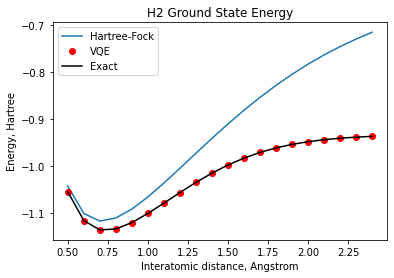

### Manually define a circuit

In [38]:
def circuit_uccd_reduced(param, num_qubits, initial_state):
    qr = QuantumRegister(num_qubits, 'q')
    qc = QuantumCircuit(qr)
    occupied = list(reversed(initial_state.bitstr))
    
    for i in range(num_qubits):
        if occupied[i]:
            qc.x(qr[i])
    
    qc.rx(-np.pi/2, qr[0])
    for i in range(1, num_qubits):
        qc.h(qr[i])

    for i in range(num_qubits - 1):
        qc.cnot(qr[i], qr[i + 1])

    qc.u1(param[0], qr[num_qubits-1])

    for i in reversed(range(num_qubits-1)):
        qc.cnot(qr[i], qr[i + 1])
    
    qc.rx(np.pi/2, qr[0])
    for i in range(1, num_qubits):
        qc.h(qr[i])
        
    return qc

The reduced ansatz is much smaller than the UCCSD one.

In [18]:
number_parameters = 1
params = ParameterVector('params', number_parameters)
custom_var_form = circuit_uccd_reduced(params, 4, initial_state)
custom_var_form.draw()

┌───┐┌───────────┐                                               »
q_0: ┤ X ├┤ RX(-pi/2) ├──■─────────────────────────────────────────■──»
     ├───┤└───────────┘┌─┴─┐                                     ┌─┴─┐»
q_1: ┤ H ├─────────────┤ X ├──■───────────────────────────────■──┤ X ├»
     ├───┤    ┌───┐    └───┘┌─┴─┐                           ┌─┴─┐├───┤»
q_2: ┤ X ├────┤ H ├─────────┤ X ├──■─────────────────────■──┤ X ├┤ H ├»
     ├───┤    └───┘         └───┘┌─┴─┐┌───────────────┐┌─┴─┐├───┤└───┘»
q_3: ┤ H ├───────────────────────┤ X ├┤ U1(params[0]) ├┤ X ├┤ H ├─────»
     └───┘                       └───┘└───────────────┘└───┘└───┘     »
«     ┌──────────┐
«q_0: ┤ RX(pi/2) ├
«     └──┬───┬───┘
«q_1: ───┤ H ├────
«        └───┘    
«q_2: ────────────
«                 
«q_3: ────────────
«

In [19]:
print(custom_var_form.decompose().depth())
print(len(custom_var_form.decompose()))

10
17


VQE supports custom circuits. We can see that the energy is very close to the exact energy.

In [70]:
algo = VQE(qubitOp, custom_var_form, optimizer)
custom_result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
custom_energy = custom_result.eigenvalue.real + repulsion_energy
E_diff_custom = (custom_energy - exact_energy) * au_to_kcal
print(f"VQE on manual circuit:", f'{custom_energy:.8f}', 'Hartree')
print("Energy difference:", f'{E_diff_custom:.8f}', 'kcal/mol')

VQE on manual circuit: -1.13730603 Hartree
Energy difference: 0.00000336 kcal/mol


Finally, let's see how does the $H_2$ molecule ground-state look:

In [72]:
ground_state_vector = algo.get_optimal_vector()

coefficients = np.absolute(ground_state_vector)
states = np.argwhere(coefficients > 1e-6)

for state in states:
    coeff = coefficients[state][0]
    if ground_state_vector[state].real >= 0:
        sign = '+'
    else:
        sign = '-'

    representation = f'|{int(state):04b}>'
    print(f'{sign}{coeff:.4f}*{representation}', end=' ')

print()

-0.9938*|0101> +0.1115*|1010> 
